#### Autogluon results for models built with 2259 imputed features, from which 15 balanced training datasets were obtained, and models were evaluated on 10 imbalanced test sets

In [ ]:
import pandas as pd
output_path = '/home/seguraab/ara-kinase-prediction/output_clf/ara_m_autogluon_2259_imp_feats'
res = []
imp = {}
for i in range(10): # test sets
    for j in range(15): # balanced training sets
        dirp = f'{output_path}/ara_m_autogluon_test_{i}_balanced_{j}'
        i_j_res = pd.read_csv(f'{dirp}/ara_m_autogluon_test_{i}_balanced_{j}_RESULTS.csv', index_col=0)
        i_j_res.insert(0, 'Tag', f'ara_m_autogluon_test_{i}_balanced_{j}')
        res.append(i_j_res)
        
        i_j_imp = pd.read_csv(f'{dirp}/ara_m_autogluon_test_{i}_balanced_{j}_IMPORTANCE.csv', index_col=0)
        imp[f'ara_m_autogluon_test_{i}_balanced_{j}'] = i_j_imp
        del i_j_res, i_j_imp
        
res = pd.concat(res, axis=0)
# res.to_csv(f'{output_path}/ara_m_autogluon_2259_imp_feats_balanced_RESULTS.csv', index=False)

imp = pd.concat(imp, axis=1)
new_cols = [f'{level0}_{level1}' for level0, level1 in \
    zip(imp.columns.get_level_testues(0), imp.columns.get_level_testues(1))]
imp.columns = new_cols
# imp.to_csv(f'{output_path}/ara_m_autogluon_2259_imp_feats_balanced_IMPORTANCE.csv', index=False)

/tmp/ipykernel_1143545/387640194.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  res[['model', 'score_test', 'score_val']].plot(kind='box', title='Model performance', by='model', ax=ax, rot=55)


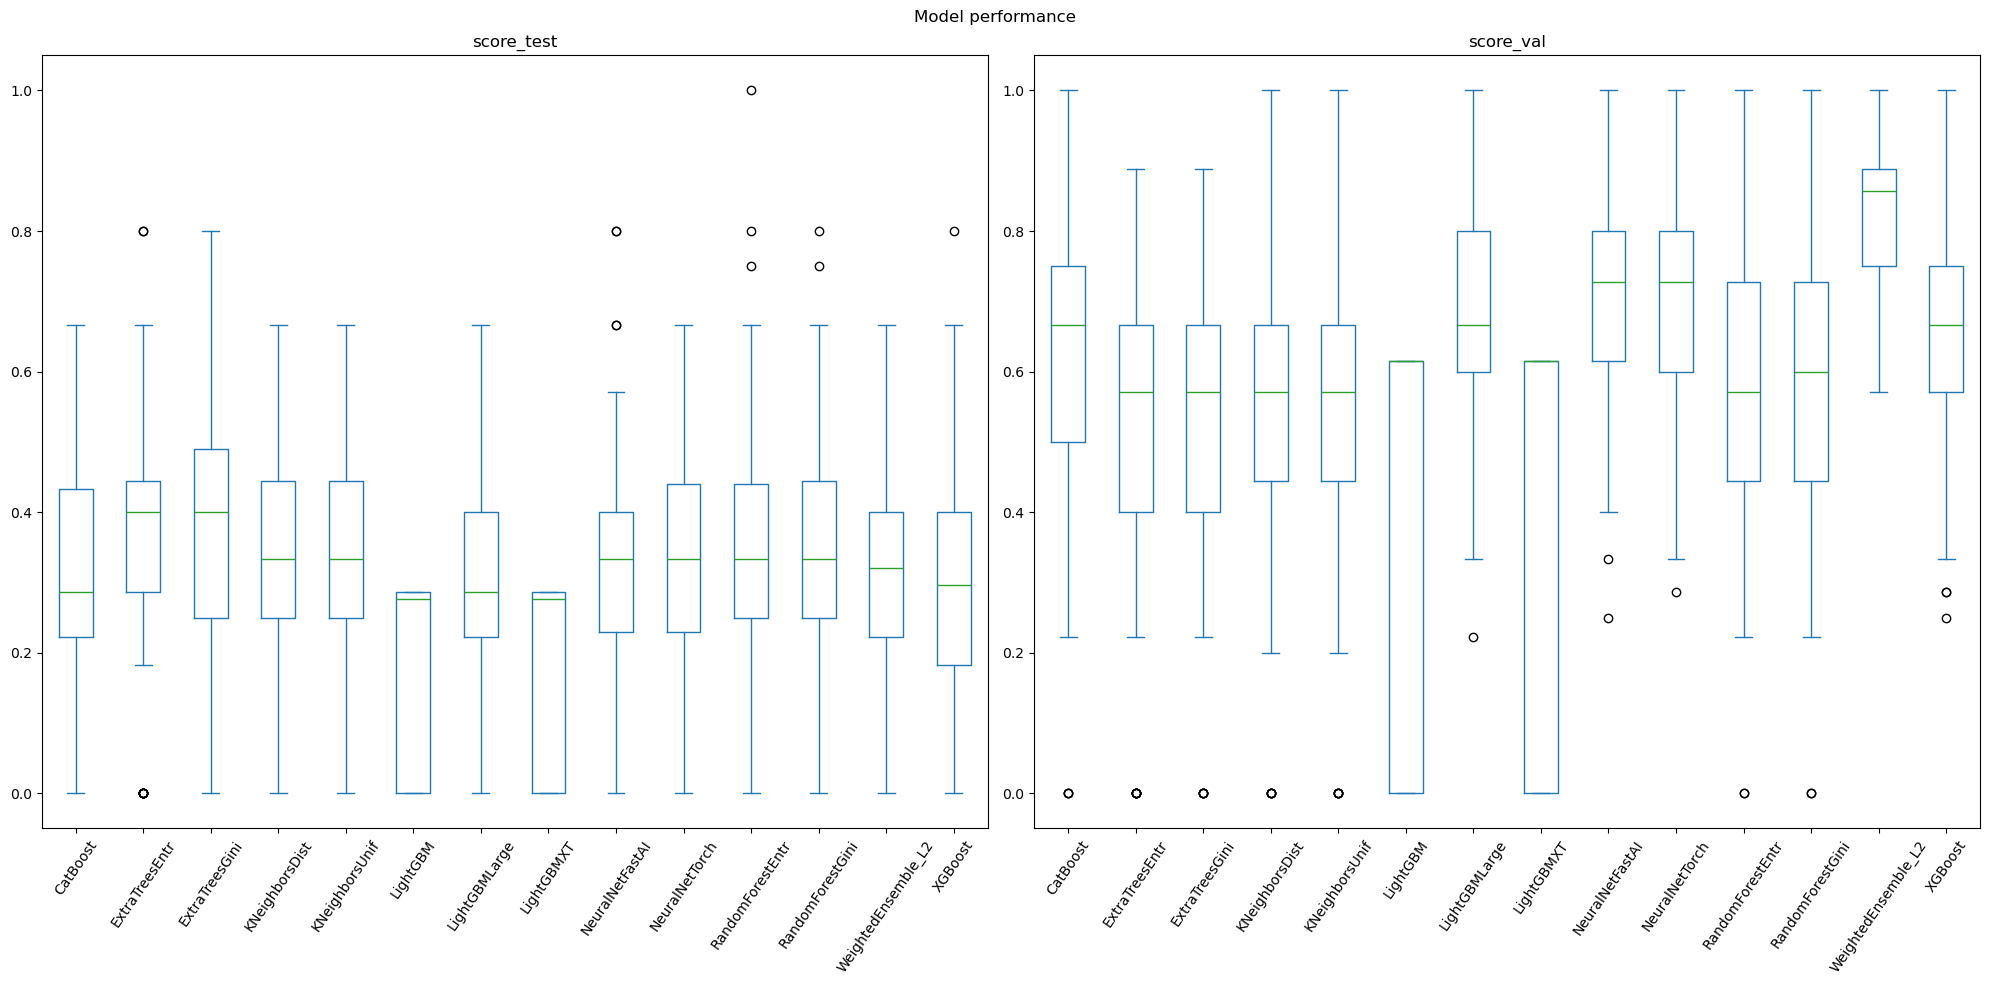

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

output_path = '/home/seguraab/ara-kinase-prediction/output_clf/ara_m_autogluon_2259_imp_feats'
res = pd.read_csv(f'{output_path}/ara_m_autogluon_2259_imp_feats_balanced_RESULTS.csv', header=0)

fig, ax = plt.subplots(figsize=(20, 10))
res[['model', 'score_test', 'score_val']].plot(kind='box', title='Model performance', by='model', ax=ax, rot=55)
plt.tight_layout()

#### XGBoost Classification Model Performances for models trained on 2259 features, from which 15 balanced datasets were obtained for each of the 10 test sets

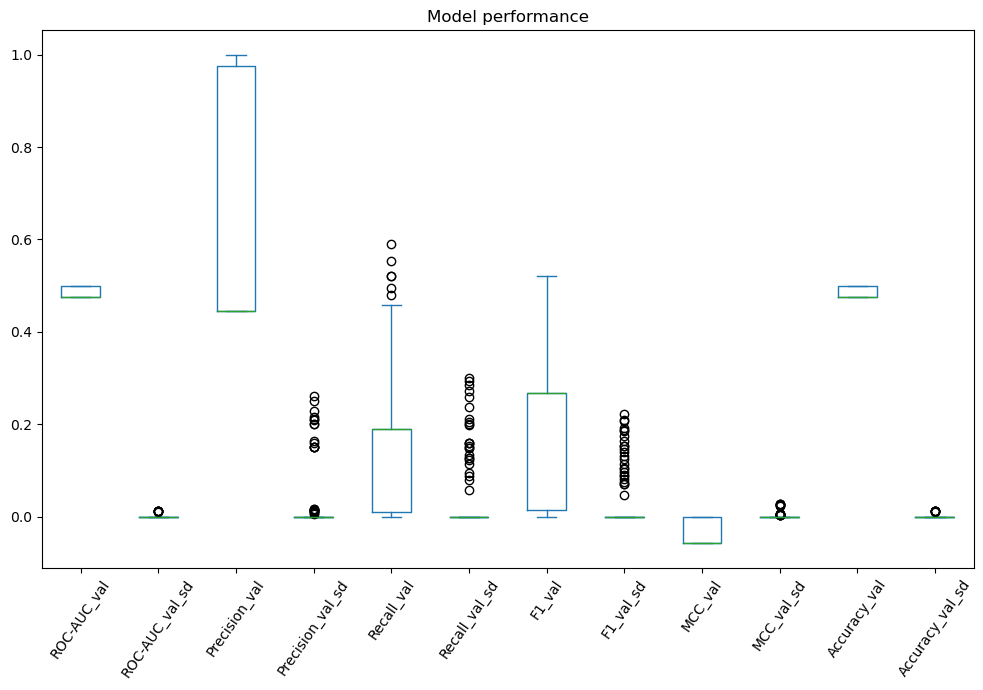

In [14]:
res = pd.read_csv('/home/seguraab/ara-kinase-prediction/output_clf/ara_m_kfold_ht_2259_imp_feats/RESULTS_xgboost.tsv', sep='\t', header=0)
fig, ax = plt.subplots(figsize=(10, 7))
res[['ROC-AUC_val', 'ROC-AUC_val_sd', 'Precision_val', 'Precision_val_sd',
     'Recall_val', 'Recall_val_sd', 'F1_val', 'F1_val_sd', 'MCC_val',
     'MCC_val_sd', 'Accuracy_val', 'Accuracy_val_sd']].\
        plot(kind='box', title='Model performance', ax=ax, rot=55)
plt.tight_layout()

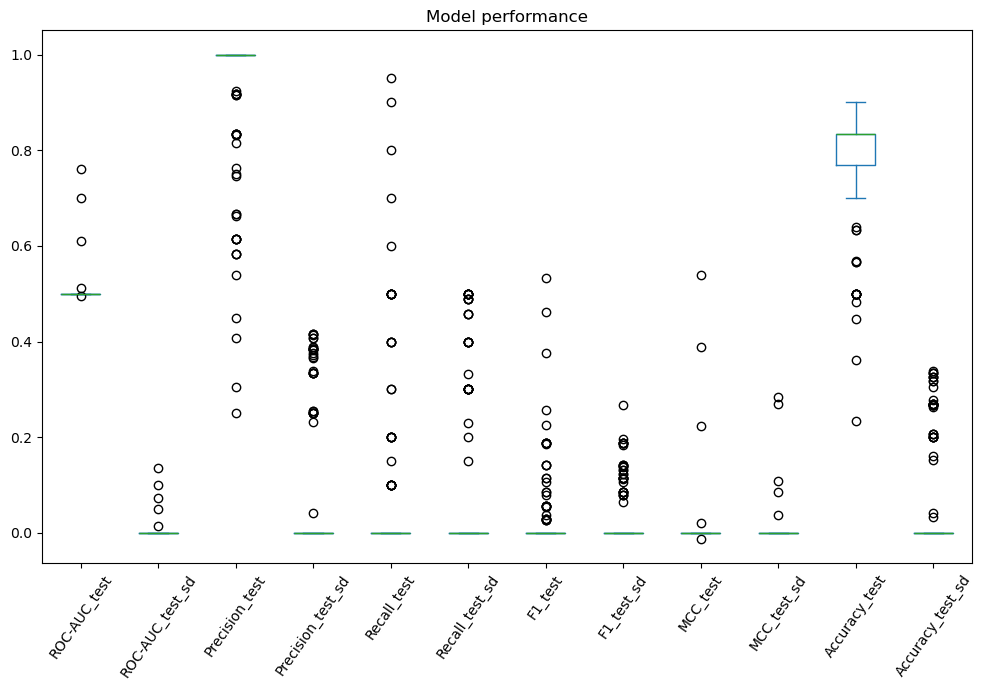

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
res[['ROC-AUC_test', 'ROC-AUC_test_sd', 'Precision_test', 'Precision_test_sd',
     'Recall_test', 'Recall_test_sd', 'F1_test', 'F1_test_sd', 'MCC_test',
     'MCC_test_sd', 'Accuracy_test', 'Accuracy_test_sd']].\
        plot(kind='box', title='Model performance', ax=ax, rot=55)
plt.tight_layout()

### Feature selection results for XGBoost models built using the 2259 imputed features, 15 balanced training sets, and 10 imbalanced test sets. Feature selection was performed with RandomForest.

In [ ]:
import pandas as pd
import datatable as dt
import numpy as np

# Get the best feature selection run per test set and balanced dataset
clf_res = dt.fread('/home/seguraab/ara-kinase-prediction/output_clf/ara_m_kfold_ht_2259_imp_feats_fs/RESULTS_xgboost.tsv').to_pandas()
clf_res.insert(0, 'TestSet', clf_res.Tag.str.split('_').str[8])
clf_res.insert(0, 'BalancedTrainSet', clf_res.Tag.str.split('_').str[10])
best_runs = clf_res.groupby(['TestSet', 'BalancedTrainSet']).apply(lambda x: x['F1_test'].idxmax())
clf_res_best = clf_res.iloc[best_runs]
clf_res_best.to_csv('/home/seguraab/ara-kinase-prediction/output_clf/ara_m_kfold_ht_2259_imp_feats_fs/RESULTS_xgboost_best.csv', index=False)
# note on clf_res_best: the best run F1 test is really bad even though F1_test looks good.

# Get the average performance across different feature subsets per test set and balanced dataset
clf_res['TestSet'] = clf_res['TestSet'].astype(int)
clf_res['BalancedTrainSet'] = clf_res['BalancedTrainSet'].astype(int)
clf_res_avg = clf_res.select_dtypes(np.number).groupby(['TestSet', 'BalancedTrainSet']).mean()
clf_res_avg.to_csv('/home/seguraab/ara-kinase-prediction/output_clf/ara_m_kfold_ht_2259_imp_feats_fs/RESULTS_xgboost_avg.csv')

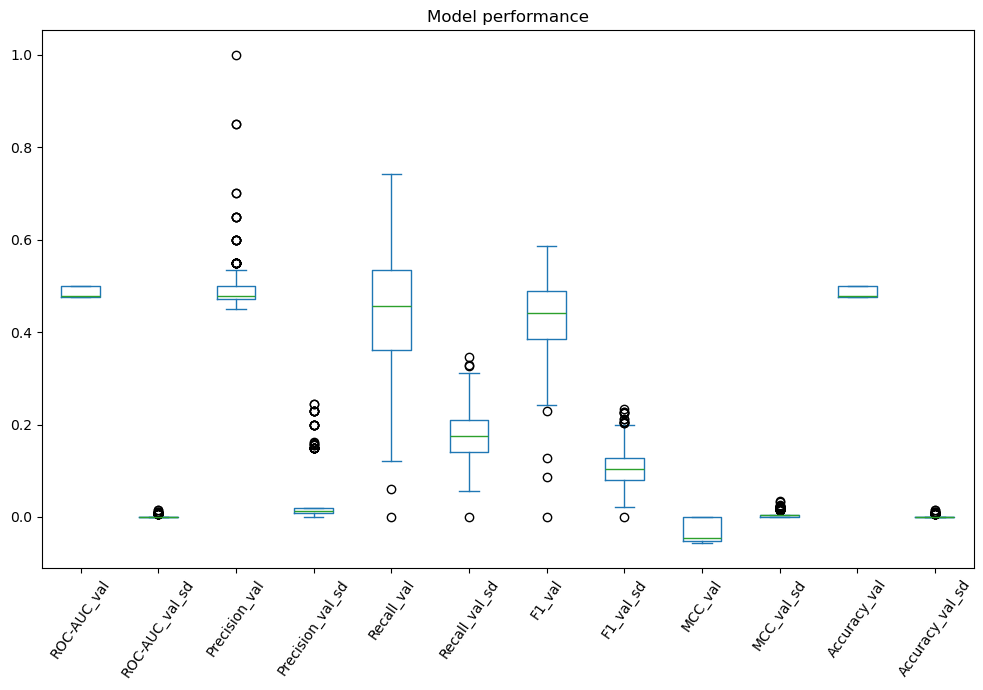

In [16]:
res = pd.read_csv('/home/seguraab/ara-kinase-prediction/output_clf/ara_m_kfold_ht_2259_imp_feats_fs/RESULTS_xgboost_best.csv', header=0)
fig, ax = plt.subplots(figsize=(10, 7))
res[['ROC-AUC_val', 'ROC-AUC_val_sd', 'Precision_val', 'Precision_val_sd',
     'Recall_val', 'Recall_val_sd', 'F1_val', 'F1_val_sd', 'MCC_val',
     'MCC_val_sd', 'Accuracy_val', 'Accuracy_val_sd']].\
        plot(kind='box', title='Model performance', ax=ax, rot=55)
plt.tight_layout()

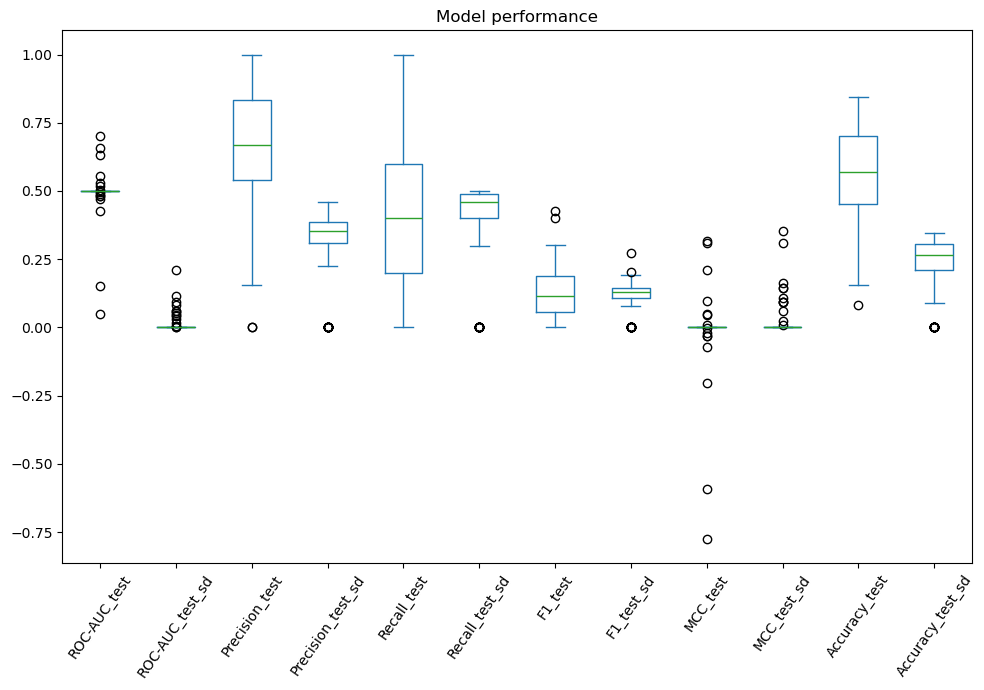

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
res[['ROC-AUC_test', 'ROC-AUC_test_sd', 'Precision_test', 'Precision_test_sd',
     'Recall_test', 'Recall_test_sd', 'F1_test', 'F1_test_sd', 'MCC_test',
     'MCC_test_sd', 'Accuracy_test', 'Accuracy_test_sd']].\
        plot(kind='box', title='Model performance', ax=ax, rot=55)
plt.tight_layout()

#### Feature selection curves
None of the models have a test set performance above 0.5 with a reasonable validation F1.
```python
>>> clf_res.loc[clf_res.F1_test > 0.5, 'F1_val']
# 387    0.330136
```

In [ ]:
import matplotlib.pyplot as plt

# Plotting the F1 score
for test_set in range(10):
    fig, ax = plt.subplots(5, 3, figsize=(8.5, 14.17), sharex=True, sharey=True) # to make the plots square
    for i in range(5):
        for j in range(3):
            balanced_train_set = i * 3 + j
            clf_res_subset = clf_res[(clf_res['TestSet'] == test_set) &\
                (clf_res['BalancedTrainSet'] == balanced_train_set)]
            clf_res_subset = clf_res_subset.sort_values('NumFeatures')
            ax[i, j].plot(clf_res_subset['NumFeatures'], clf_res_subset['F1_val'],
                          label='F1_val', color='red')
            ax[i, j].plot(clf_res_subset['NumFeatures'], clf_res_subset['F1_test'],
                          label='F1_test', color='blue')
            ax[i, j].set_title(f'Balanced Train Set {balanced_train_set}')
            ax[i, j].set_xlabel('Number of Features')
            ax[i, j].set_ylabel('F1 score')
            ax[i, j].legend()
    
    fig.suptitle(f'Test Set {test_set}')
    plt.tight_layout()
    plt.savefig(f'/home/seguraab/ara-kinase-prediction/output_clf/ara_m_kfold_ht_2259_imp_feats_fs/0_figure_test_{test_set}_feature_selection.pdf')
    plt.close()

#### Regression models on the 2259 imputed features

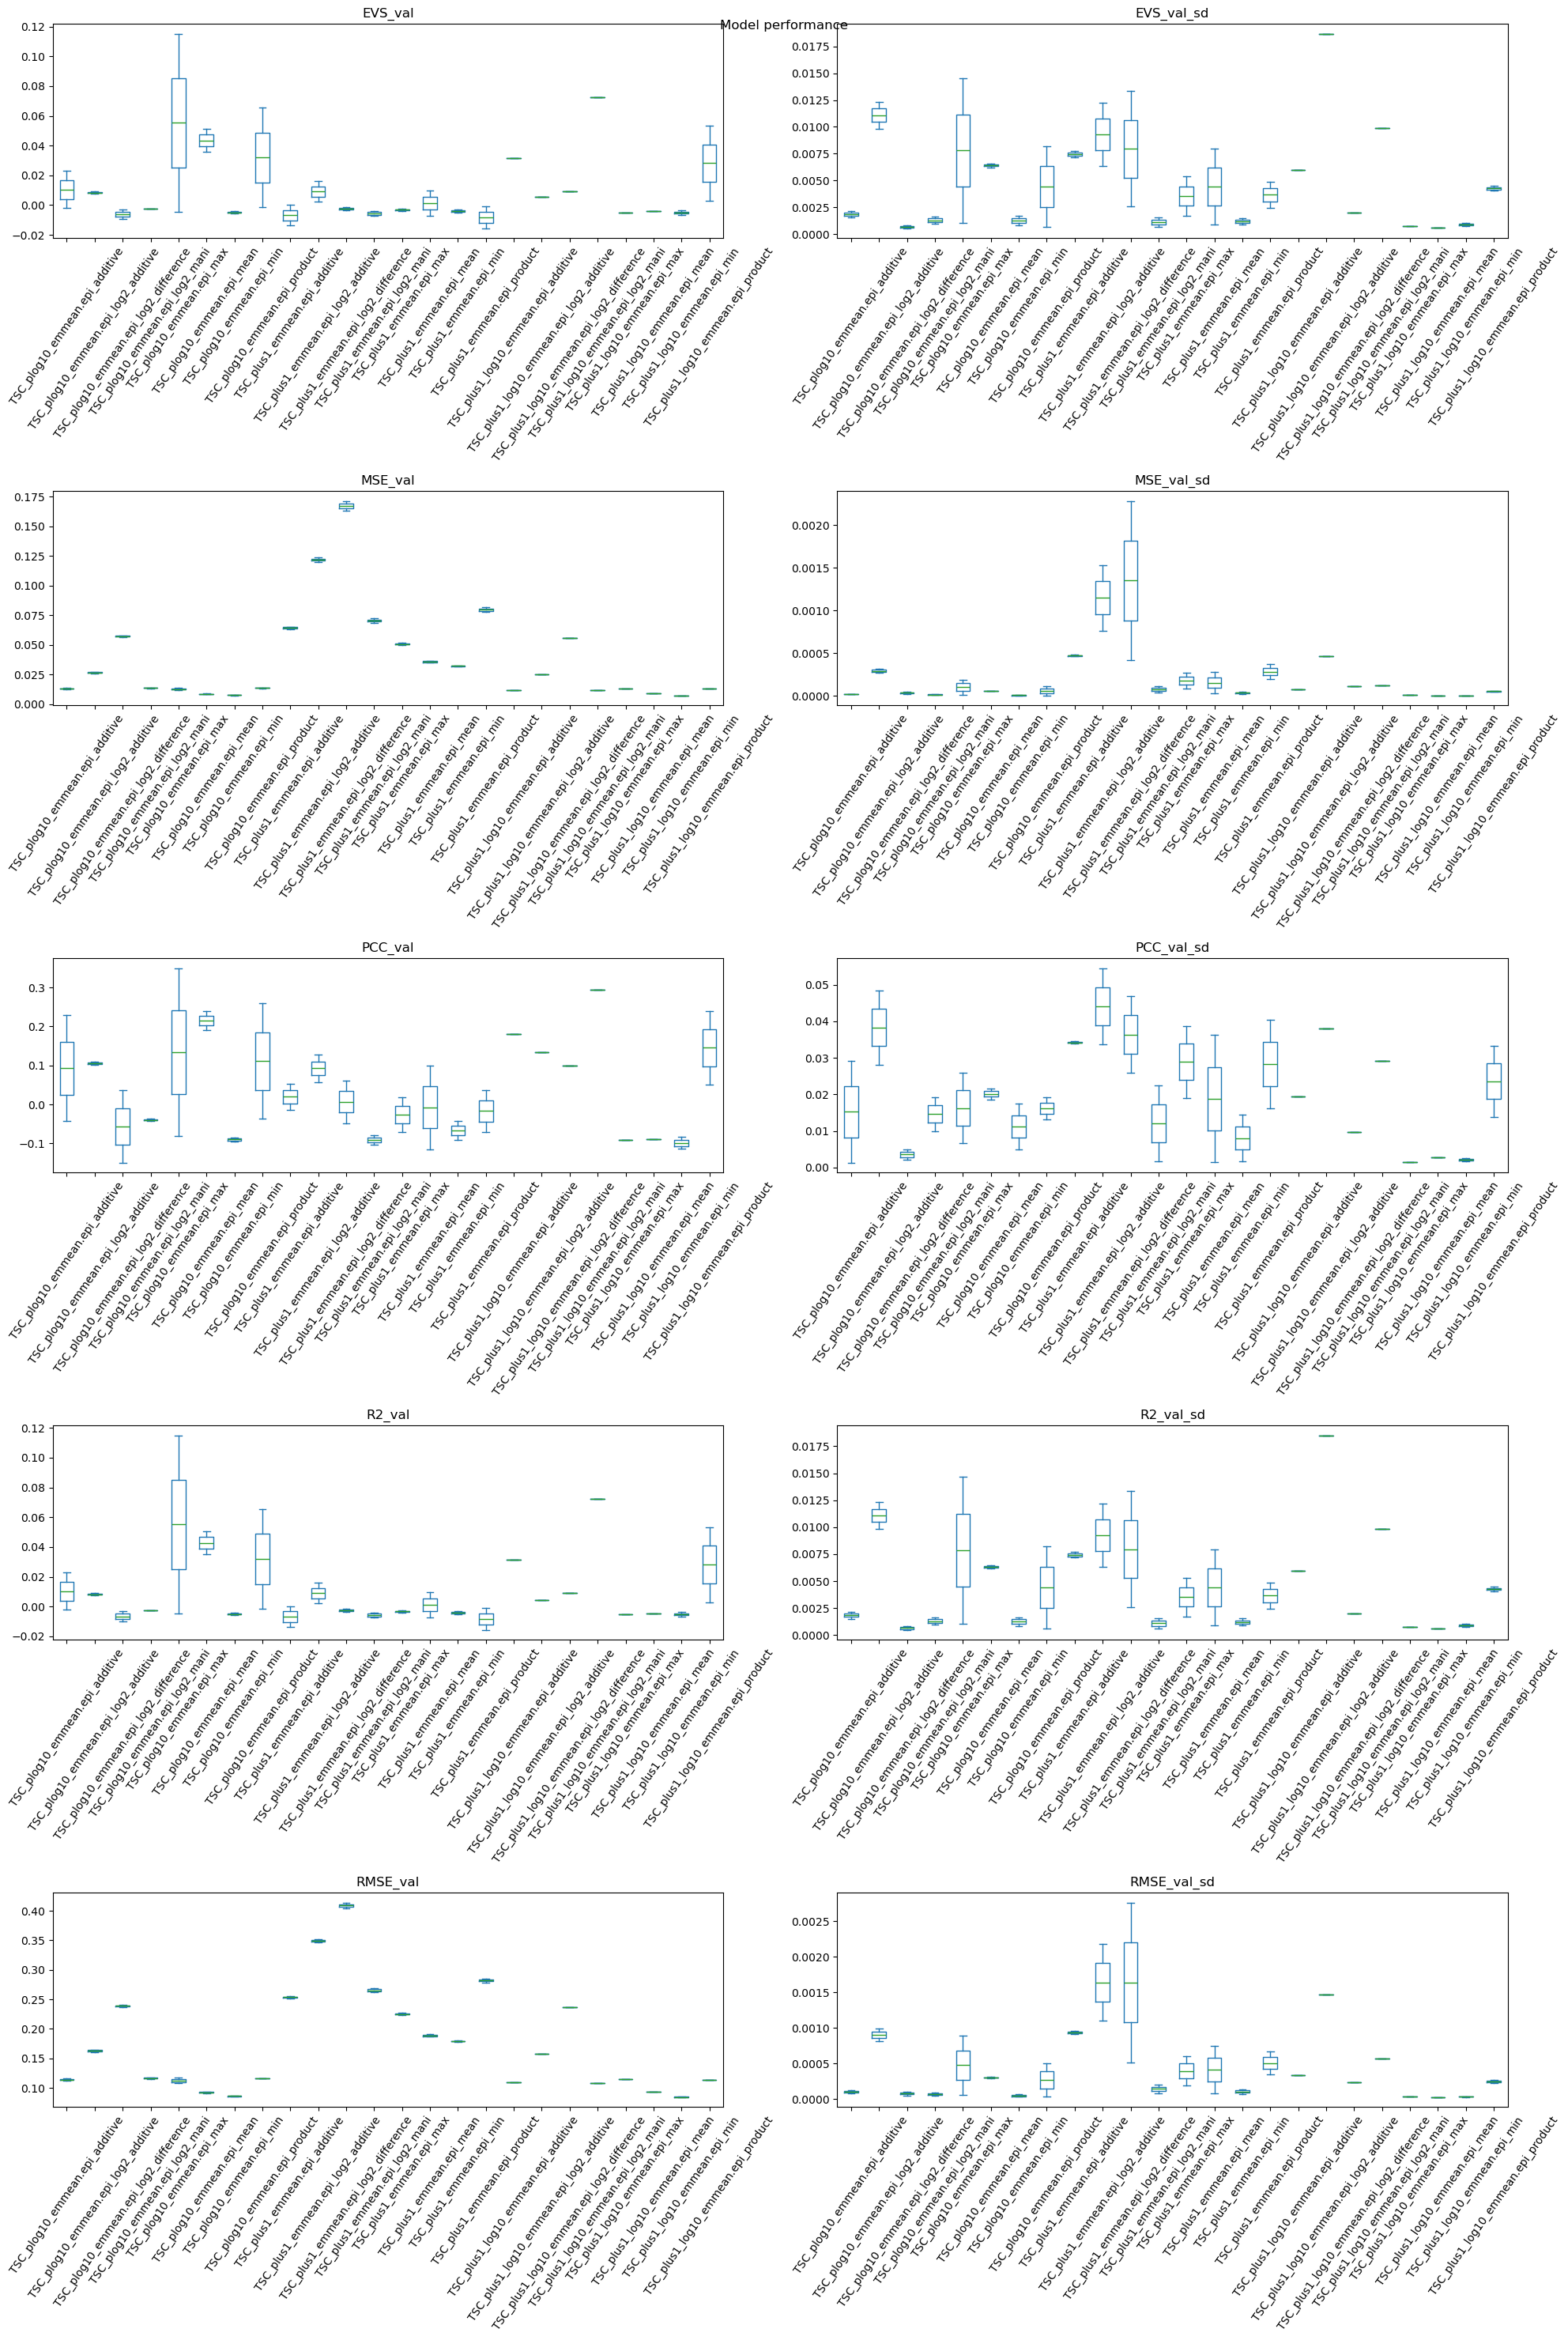

In [25]:
res = pd.read_csv("/home/seguraab/ara-kinase-prediction/output_reg/ara_m_kfold_ht_2259_imp_feats/RESULTS_xgboost.tsv", sep="\t", header=0) # I ran this prematurely, it only has results for test_set 0 and part of test_set 1
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))
res[['Y', 'MSE_val', 'MSE_val_sd', 'RMSE_val', 'RMSE_val_sd',
     'EVS_val', 'EVS_val_sd', 'R2_val', 'R2_val_sd', 'PCC_val',
     'PCC_val_sd']].plot(kind='box', title='Model performance', ax=ax, rot=55, by='Y')
plt.tight_layout()


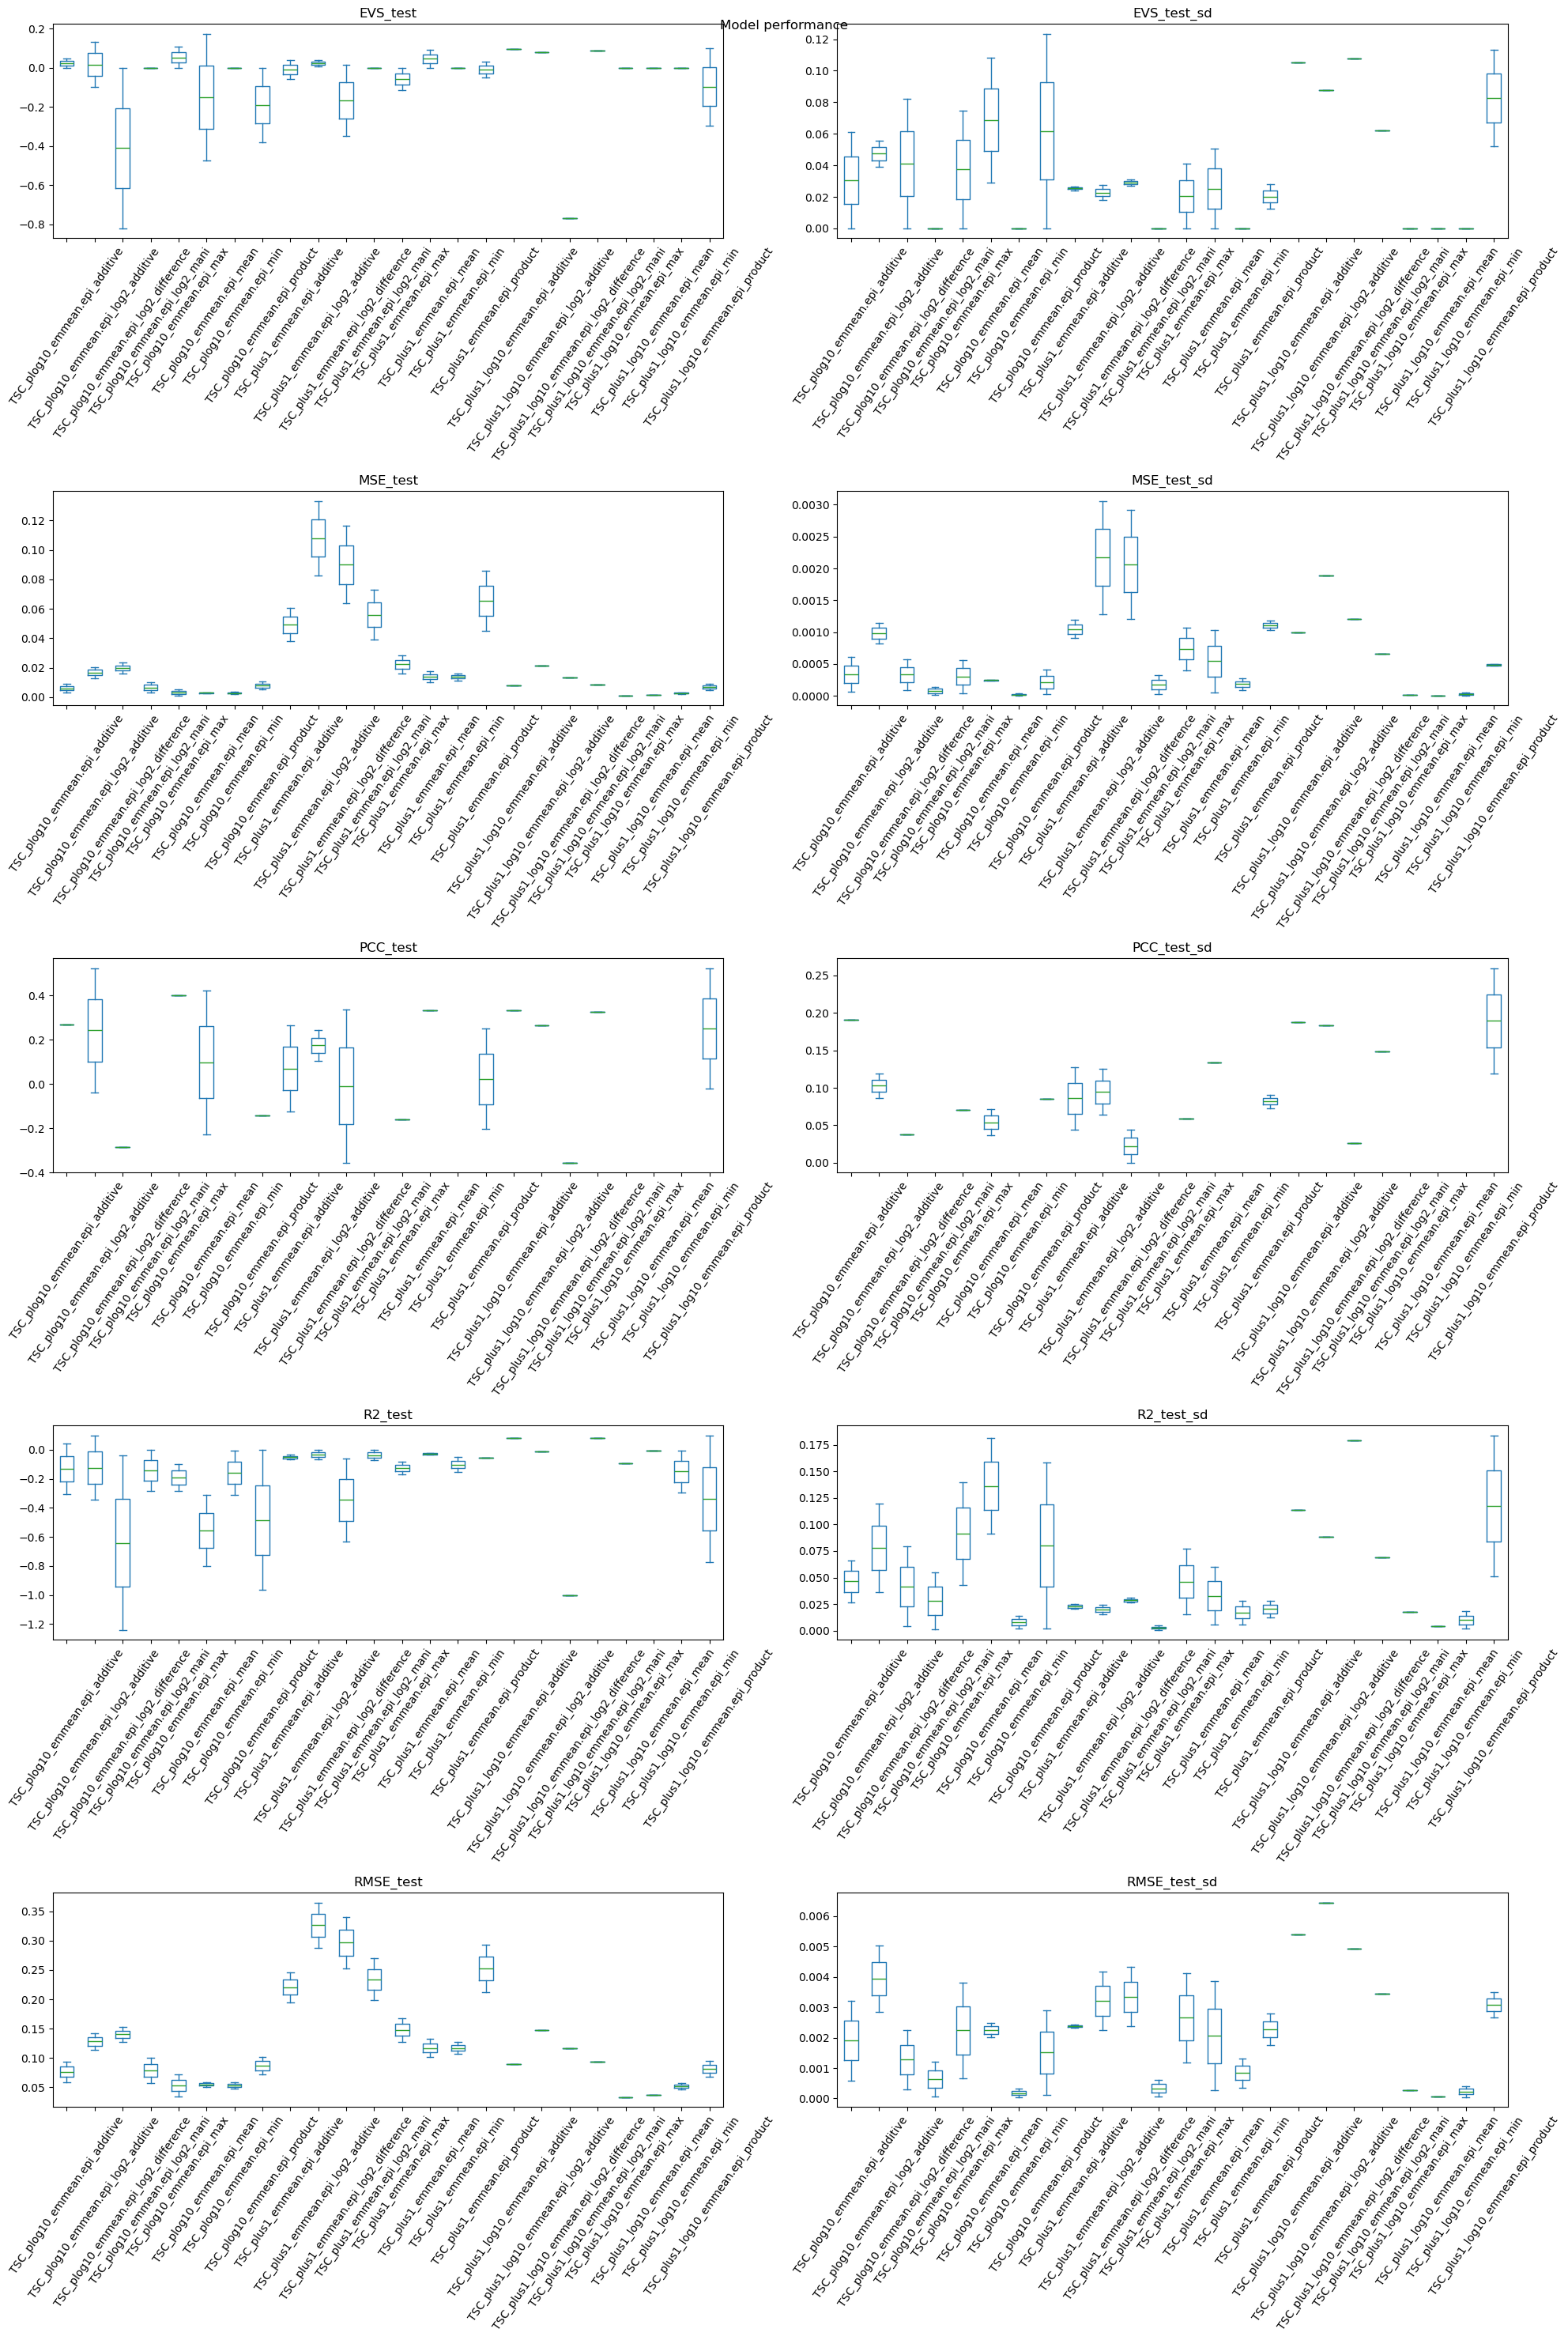

In [27]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))
res[['Y', 'MSE_test', 'MSE_test_sd', 'RMSE_test', 'RMSE_test_sd',
     'EVS_test', 'EVS_test_sd', 'R2_test', 'R2_test_sd', 'PCC_test',
     'PCC_test_sd']].plot(kind='box', title='Model performance', ax=ax, rot=55, by='Y')
plt.tight_layout()